In [ ]:
import networkx as nx
import numpy as np
import os

# Generating the graph
The graph is generated by processing the available data.
Note: some nodes are missing dates or abstract (or both), in that case the attributes will be empty.

In [ ]:
#dataset filenames
dataset_file = "data/Cit-HepTh.txt"
dataset_dates= "data/Cit-HepTh-dates.txt"
abs_dir = "data/abstracts" 

In [3]:
G = nx.DiGraph();
id_length = 7

#Reading the graph from the edge list
with open(dataset_file) as file:
    for line in file.readlines():
        if (line[0] == '#'): continue
        nodes = tuple(int(x) for x in line.split("\t"))
        n1, n2 = nodes
        G.add_node(n1)
        G.add_node(n2)
        G.add_edge(n1,n2)

In [4]:
#remapping the nodes so that the ID corresponds to the date format and always has 7 characters
mapping = {node: str(node).zfill(id_length) for node in G}
nx.relabel_nodes(G, mapping, copy=False)

In [5]:
n = len(G.nodes())
e = len(G.edges())
print("Nodes: {} - Edges: {}".format(n, e))

Nodes: 27770 - Edges: 352807


In [6]:
# Reading the date info from the available file.
# There are more dates than needed, and most of them do not match the node ids
years = dict()
months = dict()
with open(dataset_dates, encoding="utf8") as file:
    for line in file:
        if (line.startswith("#")): continue
        line = line[2:] if line.startswith("11") else line
        values = line.split()
        node = values[0]
        date = values[1].split("-")
        years[node] = date[0]
        months[node] = date[1]

print(len(years.keys()), len(months.keys()))

37201 37201


In [7]:
#Applying the extracted data to the graph, inserting it as attributes
Y_dict = {node: years.get(node,"na")  for node in G}
M_dict = {node: months.get(node,"na") for node in G}
nx.set_node_attributes(G, Y_dict, "year")
nx.set_node_attributes(G, M_dict, "month")

In [8]:
date_count = np.count_nonzero([1 if attrs['year'] != "na" else 0 for n,attrs in G.nodes(data=True)])
print("Nodes with a date: {} out of {}".format(date_count, len(G.nodes())))

Nodes with a date: 11441 out of 27770


Reading additional info from the abstracts

In [9]:
year_dirs = [name for name in os.listdir(abs_dir)]
print(year_dirs)

['1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003']


In [11]:
missing = 0
found = 0
title_dict = dict()
auths_dict = dict();

# Script that tries to find the abstract file from the subfolders
for node,attrs in G.nodes(data=True):
    y = attrs["year"]
    yrs = [y] if y != "na" else year_dirs
    for year in yrs:
        try:
            with open("{}/{}/{}.abs".format(abs_dir,year,node)) as abstract:
                found += 1
                if (y == "na"): attrs['year'] = year
                for line in abstract:
                    if (line.startswith("Title:")):
                        title_dict[node] = line.replace("Title:", "").strip()
                    elif (line.startswith("Authors:")):
                        auths_dict[node] = line.replace("Authors:", "").strip()
                break
        except FileNotFoundError:
            missing += 1

print("found: {}, missing: {}".format(found, missing))

found: 27757, missing: 84156


In [12]:
nx.set_node_attributes(G, title_dict, "title")
nx.set_node_attributes(G, auths_dict, "authors")

In [13]:
nx.write_graphml(G, "graphs/network-raw.graphml")
nx.write_gpickle(G, "graphs/network-raw.gpickle")

# Global Measures
Reading the graph from file and measuring the main network measures.

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
G = nx.read_gpickle("graphs/network-raw.gpickle")
print("Nodes: {} - Edges: {}".format(len(G.nodes()), len(G.edges())))

Nodes: 27770 - Edges: 352807


In [3]:
# density measures the fraction of existing edges out of the possible edges
# undirectd network: 2m/n(n-1)

density = nx.density(G)
print("Density: {:.5f}".format(density))

Density: 0.00046


In [4]:
# Mean of the average clustering coefficients for every node
avg_cc = nx.average_clustering(nx.Graph(G))
print("Average cc: {:.5f}".format(avg_cc))

Average cc: 0.31202


In [5]:
# Fraction of all possible triangles that exist in the network. 
# Called transitivity, a measure of transitive closure. 
transitivity = nx.transitivity(G)
print("Transitivity: {:.5f}".format(transitivity))

Transitivity: 0.13277


In [6]:
# Converted G into an undirected graph
G1 = G.to_undirected()
dict_clco = nx.clustering(G1)
dict_tris = nx.triangles(G1)

In [7]:
dict_deg = {node: val for (node, val) in G.degree()}
dict_indeg  = {node: val for (node, val) in G.in_degree()}
dict_outdeg = {node: val for (node, val) in G.out_degree()}

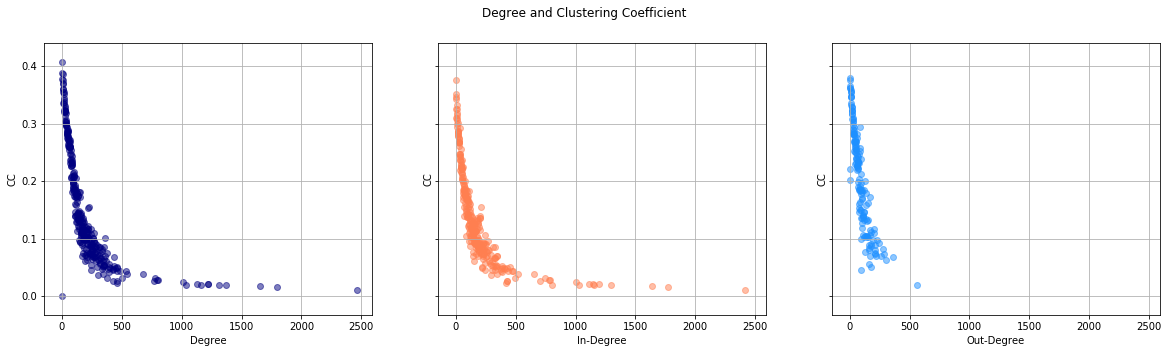

In [8]:
# Plotting the degree correlated to the clustering coefficient
deg_cc = pd.concat([pd.Series(dict_deg), pd.Series(dict_indeg), pd.Series(dict_outdeg), pd.Series(dict_clco)], axis=1)
deg_cc.columns = ("Degree", "In-Degree", "Out-Degree","CC")

labels = [["Degree", "CC"], ["In-Degree", "CC"], ["Out-Degree", "CC"]]

data_deg = deg_cc[labels[0]].groupby(labels[0][0]).mean().reset_index()
data_in  = deg_cc[labels[1]].groupby(labels[1][0]).mean().reset_index()
data_out = deg_cc[labels[2]].groupby(labels[2][0]).mean().reset_index()
data = [data_deg, data_in, data_out]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)
f.set_figwidth(20)
f.set_figheight(5)
title = "Degree and Clustering Coefficient"
colors = ['navy','coral', 'dodgerblue']

for names, df, ax, c in zip(labels, data, [ax1, ax2, ax3], colors):
    values = df.values.astype(np.float)
    ax.scatter(values[:,0], values[:,1],c=c, alpha=0.5)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])
    ax.grid()
f.suptitle(title)
plt.savefig("images/{}.png".format(title), dpi=600)

Text(0.5,0.98,'Degrees histograms')

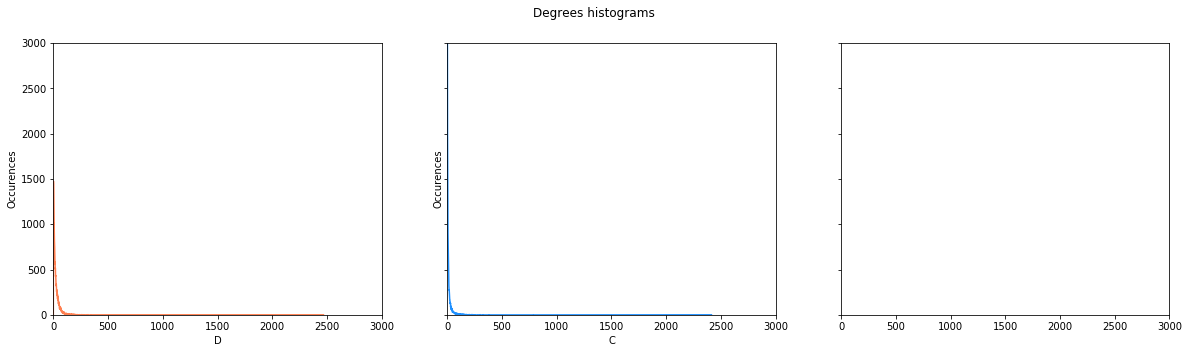

In [120]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
f.set_figwidth(20)
f.set_figheight(5)
title = "Degrees histograms"

data = [dict_deg, dict_indeg, dict_outdeg]
for names, degrees, ax, c in zip(labels, data, [ax1, ax2, ax3], colors):
    d = list(degrees.values())
    bins = np.bincount(d)
    ax.plot(np.arange(0,len(bins)), bins, c)
    ax.set_xlim([1,3000])
    ax.set_ylim([1,3000])
    #ax.hist(degrees.values(), bins=100)
    #ax.set_yscale("log")
    ax.set_xlabel(names[0])
    ax.set_ylabel("Occurences")
f.suptitle(title)
#plt.savefig("images/{}.png".format(title), dpi=600)

In [10]:
means = deg_cc.mean(axis=0)
stds = deg_cc.std(axis=0)
print("Mean:\n",means)
print("St. Deviations:\n",stds)

Mean:
 Degree        25.409219
In-Degree     12.704609
Out-Degree    12.704609
CC             0.312019
dtype: float64
St. Deviations:
 Degree        45.340868
In-Degree     39.816695
Out-Degree    15.967372
CC             0.221325
dtype: float64


# Generated Graph comparison

In [51]:
m = int(np.round(means["Degree"]))
G2 = nx.barabasi_albert_graph(len(G), m)

In [66]:
G3 = nx.powerlaw_cluster_graph(len(G), m, 0.5)

In [95]:
print("BA ", len(G2), len(G2.edges()))
print("HK ", len(G3), len(G3.edges()))

BA  27770 693625
HK  27770 692624


In [92]:
dict_clco2 = nx.clustering(G2)
dict_deg2 = {node: val for (node, val) in G2.degree()}

In [93]:
dict_clco3 = nx.clustering(G3)
dict_deg3 = {node: val for (node, val) in G3.degree()}

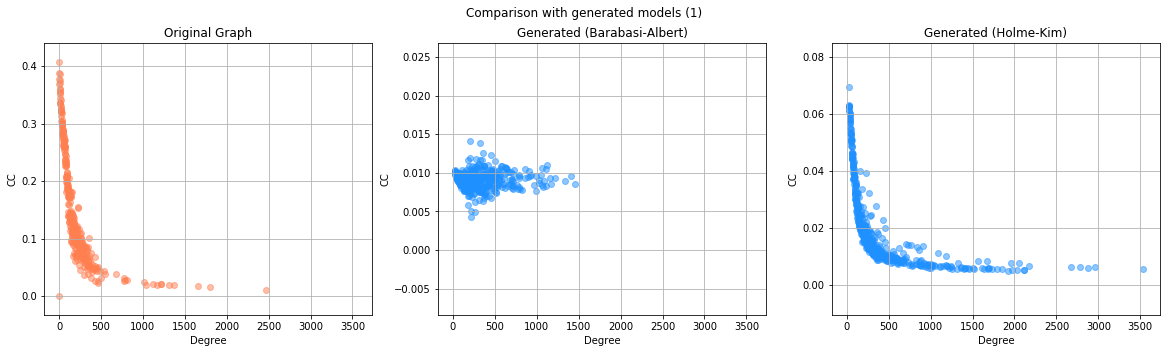

In [69]:
# Plotting the degree correlated to the clustering coefficient
deg_cc2 = pd.concat([pd.Series(dict_deg2), pd.Series(dict_clco2)], axis=1)
deg_cc2.columns = ("Degree","CC")

deg_cc3 = pd.concat([pd.Series(dict_deg3), pd.Series(dict_clco3)], axis=1)
deg_cc3.columns = ("Degree","CC")

labels = ["Degree", "CC"]
titles = ["Original Graph", "Generated (Barabasi-Albert)", "Generated (Holme-Kim)"]
data_deg2 = deg_cc2[labels].groupby(labels[0]).mean().reset_index()
data_deg3 = deg_cc3[labels].groupby(labels[0]).mean().reset_index()
data = [data_deg, data_deg2, data_deg3]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
f.set_figwidth(20)
f.set_figheight(5)
title = "Comparison with generated models (1)"
colors = ['coral', 'dodgerblue','dodgerblue']

for t, df, ax, c in zip(titles, data, [ax1, ax2, ax3], colors):
    values = df.values.astype(np.float)
    ax.scatter(values[:,0], values[:,1],c=c, alpha=0.5)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title(t)
    ax.grid()
f.suptitle(title)
plt.savefig("images/{}.png".format(title), dpi=600)

[   0 1476 1445 ...    0    0    1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


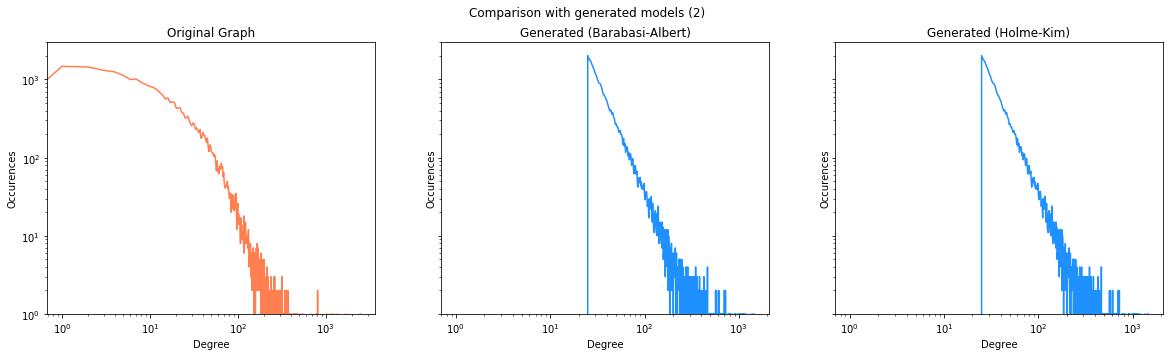

In [119]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figwidth(20)
f.set_figheight(5)
title = "Comparison with generated models (2)"

d1 = [val for (n, val) in  G.degree()]
d2 = [val for (n, val) in G2.degree()]
d3 = [val for (n, val) in G2.degree()]

data = [d1, d2, d3]
for t, d, ax, c in zip(titles, data, [ax1, ax2, ax3], colors):
    bins = np.bincount(d)
    print(bins)
    ax.loglog(np.arange(0,len(bins)), bins, c=c)
    #ax.hist(degrees.values(), bins=1000)
    ax.set_ylim([1,3000])
    ax.set_xlabel("Degree")
    ax.set_ylabel("Occurences")
    ax.set_title(t)
f.suptitle(title)
plt.savefig("images/{}.png".format(title), dpi=600)

In [11]:
# selecting node with max degree
best_node = max(dict_deg.keys(), key=(lambda key: dict_deg[key]))
print("Node: ", best_node)
print(G.nodes[best_node])
print("degree: ", dict_deg[best_node])

Node:  9711200
{'year': '1997', 'month': 'na', 'title': 'The Large N Limit of Superconformal Field Theories and Supergravity', 'authors': 'Juan M. Maldacena'}
degree:  2468


In [12]:
# selecting node with max in-degree
best_node_in = max(dict_indeg.keys(), key=(lambda key: dict_indeg[key]))
print("Node: ", best_node_in)
print(G.nodes[best_node_in])
print("in-degree (citated by): ", dict_indeg[best_node_in])

Node:  9711200
{'year': '1997', 'month': 'na', 'title': 'The Large N Limit of Superconformal Field Theories and Supergravity', 'authors': 'Juan M. Maldacena'}
in-degree (citated by):  2414


In [13]:
# selecting node with max out-degree
best_node_out = max(dict_outdeg.keys(), key=(lambda key: dict_outdeg[key]))
print("Node: ", best_node_out)
print(G.nodes[best_node_out])
print("out-degree: ", dict_outdeg[best_node_out])

Node:  9905111
{'year': '1999', 'month': '05', 'title': 'Large N Field Theories, String Theory and Gravity', 'authors': 'O. Aharony, S.S. Gubser, J. Maldacena, H. Ooguri, and Y. Oz'}
out-degree:  562


In [14]:
# Deleting the nodes that are missing some information if they do not have particular importance (citated by few papers)
missing = [n for (n, attrs) in G.nodes(data=True) if not attrs.get("title")]
for n in missing:
    print(n)
    #if (dict_indeg[n] < 100): G.remove_node(n)

0201001
0101001
0101002
0101003
0101006
0101011
0101012
0101004
0101005
0101007
0101008
0101009
0101010


# Distance measures

In [15]:
import igraph as ig

In [16]:
def list_to_dict(graph, measures):
    result = dict()
    for n in graph.vs:
        key = n["name"].zfill(7)
        result[key] = measures[n.index]
    return result

In [17]:
#reading the same graph with igraph to speed up calculations
igraph_G = ig.Graph.Read_Ncol("data/Cit-HepTh-igraph.txt", directed=True)
print(igraph_G.vcount(), igraph_G.ecount())

27770 352807


In [18]:
#Dividing into components and finding the biggest one
weak_components = igraph_G.components(mode="WEAK")
weak_components_count = len(weak_components.sizes())
weak_components_sizes = weak_components.sizes()
weak_gcc = weak_components.giant()
weak_percent = weak_gcc.vcount() / igraph_G.vcount()
print("W. Components: {}, Giant size: {} ({:.3f}%)".format(weak_components_count, weak_gcc.vcount(), weak_percent))

W. Components: 143, Giant size: 27400 (0.987%)


In [19]:
#Trying to find strongly connected components as well 
strong_components = igraph_G.components(mode="STRONG")
strong_components_count = len(strong_components.sizes())
strong_components_sizes = strong_components.sizes()
strong_gcc = strong_components.giant()
strong_percent = strong_gcc.vcount() / igraph_G.vcount()
print("S. Components: {}, Giant size: {} ({:.3f}%)".format(strong_components_count, strong_gcc.vcount(), strong_percent))

S. Components: 20086, Giant size: 7464 (0.269%)


In [20]:
wgc_eccvals = weak_gcc.eccentricity()
sgc_eccvals = strong_gcc.eccentricity()

In [21]:
wgc_ecc = list_to_dict(weak_gcc, wgc_eccvals)
sgc_ecc = list_to_dict(strong_gcc, sgc_eccvals)

In [22]:
weak_diameter = max(wgc_eccvals)
weak_radius = min(wgc_eccvals)
strong_diameter = max(sgc_eccvals)
strong_radius = min(sgc_eccvals)
print("Weak \t- diameter: {}, radius: {}".format(weak_diameter, weak_radius))
print("Strong\t- diameter: {}, radius: {}".format(strong_diameter, strong_radius))

Weak 	- diameter: 37.0, radius: 0.0
Strong	- diameter: 35.0, radius: 13.0


In [23]:
weak_center = np.argwhere(np.array(wgc_eccvals) == weak_radius)
strong_center = np.argwhere(np.array(sgc_eccvals) == strong_radius)

In [24]:
for index in strong_center:
    i = index[0]
    print("SCC center: ", strong_gcc.vs[i]["name"])

SCC center:  207245


In [25]:
#exporting the giant component for analysis
giant = max(nx.strongly_connected_component_subgraphs(G), key=len)
nx.write_graphml(giant, "graphs/network-strong-gcc.graphml")

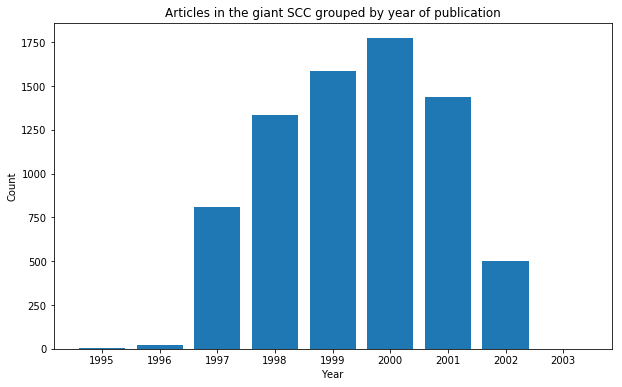

In [26]:
years = [int(a["year"]) for n,a in giant.nodes(data=True)]
bins = np.bincount(years)
x = np.nonzero(bins)
bins = bins[x]
plt.figure(figsize=(10,6))
title = "Articles in the giant SCC grouped by year of publication"
plt.title(title)
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(x[0])
plt.bar(x[0], bins)
plt.savefig("images/{}.png".format(title), dpi=600)


# Centrality measures

In [27]:
dgr = nx.degree_centrality(G)

In [28]:
clo = igraph_G.closeness()

In [29]:
eig = igraph_G.eigenvector_centrality()

In [30]:
bet = igraph_G.betweenness()

In [31]:
pgr = igraph_G.pagerank()

In [32]:
hub = igraph_G.hub_score()
aut = igraph_G.authority_score()

In [33]:
#salvarle come attributi
clo_dict = list_to_dict(igraph_G, clo)
eig_dict = list_to_dict(igraph_G, eig)
bet_dict = list_to_dict(igraph_G, bet)
pgr_dict = list_to_dict(igraph_G, pgr)
hub_dict = list_to_dict(igraph_G, hub)
aut_dict = list_to_dict(igraph_G, aut)

In [34]:
data = [dgr, clo_dict, eig_dict, bet_dict, pgr_dict, hub_dict, aut_dict]
name = ["degree_cent","closeness","eigen","betweenness","pr","hub","auth"]
for d, label in zip(data, name):
    print("Adding {}...".format(label))
    nx.set_node_attributes(G, d, label)
print(len(G.nodes()))

Adding degree_cent...
Adding closeness...
Adding eigen...
Adding betweenness...
Adding pr...
Adding hub...
Adding auth...
27770


In [35]:
nx.write_graphml(G, "graphs/network-centralities.graphml")

# Communities and Cliques

In [29]:
import community

In [35]:
G_undirected = nx.Graph(G)

In [32]:
partitions = community.best_partition(nx.Graph(G))

In [47]:
community.modularity(partitions,G_undirected)

Communities:  27770


0.6492053783818804

In [48]:
part_series = pd.Series(partitions)
part_series.sort_values()
part_series = part_series.value_counts()
part_series..head()

7     2983
9     2625
16    2129
1     2113
15    2034
dtype: int64

In [102]:
induced = community.induced_graph(partitions, G)
print("Communities: ", len(induced.nodes()))
community_sizes = {n: int(part_series[n]) for n in induced.nodes()}
nx.set_node_attributes(induced, community_sizes, "size")

Communities:  170


In [71]:
nx.write_graphml(induced, "graphs/network-communities-mod.graphml")

In [75]:
#cliques
cliques = list(nx.find_cliques(G_undirected))

In [103]:
cliques = sorted(cliques, key=lambda clique: -len(clique))
print("Number of cliques: ", len(cliques))
print("Max clique: ", len(cliques[0]))

Number of cliques:  464873
Max clique:  23


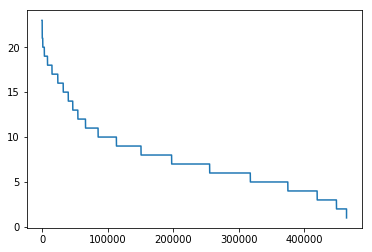

In [104]:
clique_sizes = [len(c) for c in cliques]
plt.plot(np.arange(0, len(clique_sizes)), clique_sizes)

In [108]:
G_clique = nx.subgraph(G, cliques[0])
print(len(G_clique), len(G_clique.edges()))
nx.write_graphml(G_clique, "graphs/network-clique.graphml")

23 255


In [126]:
#Manual communities by year
year_comms = dict()
for n, att in G.nodes(data=True):
    y = att["year"]
    if y not in year_comms:
        year_comms[y] = []
    year_comms[y].append(n)

In [129]:
year_partition = []
for vals in year_comms.values():
    year_partition.append(set(vals))

In [139]:
def data_f(B):
    result = dict()
    result["nnodes"] = len(B)
    result["year"] = G.nodes(data=True)[next(iter(B))]["year"]
    return result

G_years = nx.quotient_graph(G, year_partition, relabel=True, node_data=data_f)

In [140]:
print(len(G_years), len(G_years.edges()))

12 104


In [141]:
nx.write_graphml(G_years, "graphs/network-comm-years.graphml")

In [142]:
#degree correlation (assortativity...)
my_degree, their_degree = zip(*nx.average_degree_connectivity(G).items())

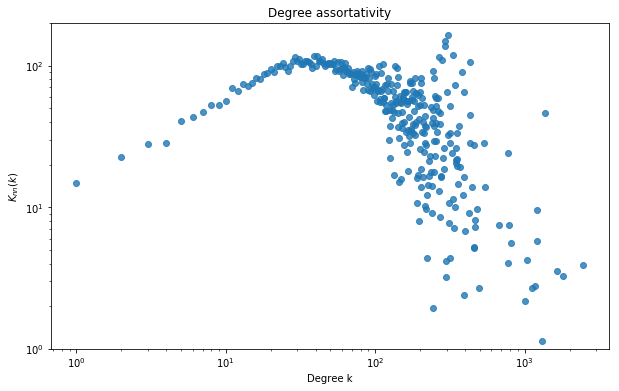

In [159]:
k_knn = pd.concat([pd.Series(v) for v in (my_degree, their_degree)], axis=1)
k_knn.columns = ("k", "Knn(k)")
k_knn = k_knn.groupby("k").mean().reset_index()
plt.figure(figsize=(10,6))
plt.scatter(k_knn["k"], k_knn["Knn(k)"], alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.ylim([1, 200])
plt.ylabel("$K_{nn}(k)$")
plt.xlabel("Degree k")
plt.title("Degree assortativity")
plt.savefig("images/{}.png".format("Degree assortativity"), dpi=600)

In [160]:
nx.attribute_assortativity_coefficient(G,'year')

0.13244467255903616

In [ ]:
import nltk

nltk.download()  
stop = set(nltk.corpus.stopwords.words('english')) | set(('&'))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [ ]:
terms = []